# Create one (1) area-weighted forcing file
We need to find how the ERA5 gridded forcing maps onto the catchment to create area-weighted forcing as SUMMA input. This involves two steps:
1. Intersect the ERA5 shape with the user's catchment shape to find the overlap between a given (sub) catchment and the forcing grid;
2. Create an area-weighted, catchment-averaged forcing time series.

The CANDEX package (https://github.com/ShervanGharari/candex_newgen) provides the necessary functionality to do this. CANDEX performs the GIS step (1, shapefile intersection) and the area-weighting step (2, create new forcing `.nc` files) as part of a single `run_candex()` call. To allow for parallelization, CANDEX can save the output from the GIS step into a restart `.csv` file which can be used to skip the GIS step. This allows (manual) parallelization of area-weighted forcing file generation after the GIS procedures have been run once. The full workflow here is thus:
1. [This script] Call `run_candex()` with ERA5 and user's shapefile, and one ERA5 forcing `.nc` file;
    - CANDEX performs intersection of both shapefiles;
    - CANDEX saves the outcomes of this intersection to a `.csv` file;
    - CANDEX creates an area-weighted forcing file from a single provided ERA5 source `.nc` file
2. [Follow-up script] Call `run_candex()` with intersection `.csv` file and all other forcing `.nc` files.
3. [Follow-up script] Apply lapse rates to temperature variable.

Parallelization of step 2 (2nd `run_candex()` call) requires an external loop that sends (batches of) the remaining ERA5 raw forcing files to individual processors. As with other steps that may be parallelized, creating code that does this is left to the user.



In [1]:
# modules
import os
import glob
import candex
from pathlib import Path
from shutil import rmtree
from shutil import copyfile
from datetime import datetime

#### Control file handling



In [2]:
# Easy access to control file folder
controlFolder = Path('../../../0_control_files')

In [3]:
# Store the name of the 'active' file in a variable
controlFile = 'control_active.txt'

In [4]:
# Function to extract a given setting from the control file
def read_from_control( file, setting ):
    
    # Open 'control_active.txt' and ...
    with open(file) as contents:
        for line in contents:
            
            # ... find the line with the requested setting
            if setting in line:
                break
    
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
       
    # Return this value    
    return substring

In [5]:
# Function to specify a default path
def make_default_path(suffix):
    
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
    
    # Get the domain folder
    domainName = read_from_control(controlFolder/controlFile,'domain_name')
    domainFolder = 'domain_' + domainName
    
    # Specify the forcing path
    defaultPath = rootPath / domainFolder / suffix
    
    return defaultPath

#### Find location of shapefiles

In [6]:
# Catchment shapefile path & name
catchment_path = read_from_control(controlFolder/controlFile,'intersect_dem_path')
catchment_name = read_from_control(controlFolder/controlFile,'intersect_dem_name')

In [7]:
# Specify default path if needed
if catchment_path == 'default':
    catchment_path = make_default_path('shapefiles/catchment_intersection/with_dem') # outputs a Path()
else:
    catchment_path = Path(catchment_path) # make sure a user-specified path is a Path()

In [8]:
# Forcing shapefile path & name
forcing_shape_path = read_from_control(controlFolder/controlFile,'forcing_shape_path')
forcing_shape_name = read_from_control(controlFolder/controlFile,'forcing_shape_name')

In [9]:
# Specify default path if needed
if forcing_shape_path == 'default':
    forcing_shape_path = make_default_path('shapefiles/forcing') # outputs a Path()
else:
    forcing_shape_path = Path(forcing_shape_path) # make sure a user-specified path is a Path()

In [10]:
import geopandas as gpd

In [11]:
shp = gpd.read_file(catchment_path/catchment_name)
shp

,GRU_ID,HRU_ID,center_lat,center_lon,HRU_area,elev_mean,geometry
0,71028585,48,51.151817,-115.580275,5.081262e+05,2113.275575,"POLYGON ((-115.57375 51.15042, -115.57375 51.1..."
1,71028585,97,51.160431,-115.575118,1.615975e+06,1694.167915,"MULTIPOLYGON (((-115.56125 51.17875, -115.5554..."
2,71028585,118,51.172347,-115.572209,4.117252e+06,1409.597142,"POLYGON ((-115.58792 51.17708, -115.58792 51.1..."
3,71028597,1,51.192707,-115.622017,1.620257e+06,2181.125044,"MULTIPOLYGON (((-115.58625 51.15625, -115.5854..."
4,71028597,49,51.177471,-115.611402,3.781836e+06,1704.881597,"MULTIPOLYGON (((-115.58458 51.16625, -115.5845..."
...,...,...,...,...,...,...,...
113,71032409,94,51.639213,-116.148346,5.102856e+06,1946.354741,"MULTIPOLYGON (((-116.17708 51.66042, -116.1754..."
114,71032422,46,51.672282,-116.303015,4.762968e+07,2407.417353,"POLYGON ((-116.34125 51.71542, -116.34042 51.7..."
115,71032422,95,51.647872,-116.323135,3.299651e+06,1934.536977,"POLYGON ((-116.31875 51.63208, -116.31875 51.6..."
116,71032440,47,51.667509,-116.451110,8.694081e+07,2398.259995,"POLYGON ((-116.47042 51.73542, -116.46708 51.7..."


#### Find where the intersection needs to go

In [12]:
# Intersected shapefile path. Name is set by CANDEX as [prefix]_intersected_shapefile.shp
intersect_path = read_from_control(controlFolder/controlFile,'intersect_forcing_path')

In [13]:
# Specify default path if needed
if intersect_path == 'default':
    intersect_path = make_default_path('shapefiles/catchment_intersection/with_forcing') # outputs a Path()
else:
    intersect_path = Path(intersect_path) # make sure a user-specified path is a Path()

In [14]:
# Make the folder if it doesn't exist
intersect_path.mkdir(parents=True, exist_ok=True)

#### Find the forcing files (merged ERA5 data)

In [15]:
# Location of merged ERA5 files
forcing_merged_path = read_from_control(controlFolder/controlFile,'forcing_merged_path')

In [16]:
# Specify default path if needed
if forcing_merged_path == 'default':
    forcing_merged_path = make_default_path('forcing/2_merged_data') # outputs a Path()
else:
    forcing_merged_path = Path(forcing_merged_path) # make sure a user-specified path is a Path()

In [17]:
# Find files in folder
forcing_files = [forcing_merged_path/file for file in os.listdir(forcing_merged_path) if os.path.isfile(forcing_merged_path/file)]

In [18]:
# Sort the files
forcing_files.sort()

#### Find where the temporary CANDEX files need to go

In [19]:
# Location for CANDEX temporary storage
forcing_candex_path = read_from_control(controlFolder/controlFile,'forcing_candex_path')

In [20]:
# Specify default path if needed
if forcing_candex_path == 'default':
    forcing_candex_path = make_default_path('forcing/3_temp_candex') # outputs a Path()
else:
    forcing_candex_path = Path(forcing_candex_path) # make sure a user-specified path is a Path()

In [21]:
# Make the folder if it doesn't exist
forcing_candex_path.mkdir(parents=True, exist_ok=True)

#### Find where the area-weighted forcing needs to go

In [22]:
# Location for CANDEX forcing output
forcing_basin_path = read_from_control(controlFolder/controlFile,'forcing_basin_avg_path')

In [23]:
# Specify default path if needed
if forcing_basin_path == 'default':
    forcing_basin_path = make_default_path('forcing/3_basin_averaged_data') # outputs a Path()
else:
    forcing_basin_path = Path(forcing_basin_path) # make sure a user-specified path is a Path()

In [24]:
# Make the folder if it doesn't exist
forcing_basin_path.mkdir(parents=True, exist_ok=True)

#### CANDEX

In [25]:
# Initialize a CANDEX object
cndx = candex.candex()

In [26]:
# Author name
cndx.author_name = 'SUMMA public workflow scripts'

In [27]:
# Data license
cndx.license = 'Copernicus data use license: https://cds.climate.copernicus.eu/api/v2/terms/static/licence-to-use-copernicus-products.pdf'

In [28]:
# Case name, used in CANDEX-generated file naes
cndx.case_name = read_from_control(controlFolder/controlFile,'domain_name')

In [29]:
# ERA5 shapefile and variable names
# Variable names can be hardcoded because we set them when we generate this shapefile as part of the workflow
cndx.source_shp     = forcing_shape_path/forcing_shape_name # shapefile
cndx.source_shp_lat = 'lat'                                 # name of the latitude field
cndx.source_shp_lon = 'lon'                                 # name of the longitude field

In [39]:
# Catchment shapefile and variable names
cndx.target_shp = catchment_path/catchment_name
cndx.target_shp_ID  = read_from_control(controlFolder/controlFile,'catchment_shp_hruid') # name of the HRU ID field
cndx.target_shp_lat = read_from_control(controlFolder/controlFile,'catchment_shp_lat')   # name of the latitude field
cndx.target_shp_lon = read_from_control(controlFolder/controlFile,'catchment_shp_lon')   # name of the longitude field

In [31]:
# ERA5 netcdf file and variable names
cndx.source_nc = str(forcing_files[0]) # first file in the list; Path() to string
cndx.var_names = ['airpres',
                  'LWRadAtm',
                  'SWRadAtm',
                  'pptrate',
                  'airtemp',
                  'spechum',
                  'windspd'] # variable names of forcing data - hardcoded because we prescribe them during ERA5 merging
cndx.var_lat   = 'latitude'  # name of the latitude dimensions
cndx.var_lon   = 'longitude' # name of the longitude dimension
cndx.var_time  = 'time'      # name of the time dimension

In [32]:
# Temporary folder where the CANDEX-generated GIS files and remapping file will be saved
cndx.temp_dir = str(forcing_candex_path) + '/' # Path() to string; ensure the trailing '/' CANDEX wants

In [33]:
# Output folder where the catchment-averaged forcing will be saved
cndx.output_dir = str(forcing_basin_path) + '/' # Path() to string; ensure the trailing '/' CANDEX wants

In [34]:
# Netcdf settings
cndx.remapped_dim_id = 'hru'     # name of the non-time dimension; prescribed by SUMMA
cndx.remapped_var_id = 'hruId'   # name of the variable associated with the non-time dimension
cndx.format_list     = ['f4']    # variable type to save forcing as. Single entry here will be used for all variables
cndx.fill_value_list = ['-9999'] # fill value

In [35]:
# Flag that we do not want the data stored in .csv in addition to .nc
cndx.save_csv  = False

In [36]:
# Flag that we currently have no remapping file
cndx.remap_csv = ''   

In [37]:
# Enforce that we want our HRUs returned in the order we put them in
cndx.sort_ID = False

In [40]:
# Run candex
# Note on centroid warnings: in this case we use a regular lat/lon grid to represent ERA5 forcing and ...
#     centroid estimates without reprojecting are therefore acceptable.
# Note on deprecation warnings: this is a CANDEX issue that cannot be resolved here. Does not affect current use.
cndx.run_candex()

candex will remap variable  airpres  from source file to variable  airpres  in remapped NeCDF file
candex will remap variable  LWRadAtm  from source file to variable  LWRadAtm  in remapped NeCDF file
candex will remap variable  SWRadAtm  from source file to variable  SWRadAtm  in remapped NeCDF file
candex will remap variable  pptrate  from source file to variable  pptrate  in remapped NeCDF file
candex will remap variable  airtemp  from source file to variable  airtemp  in remapped NeCDF file
candex will remap variable  spechum  from source file to variable  spechum  in remapped NeCDF file
candex will remap variable  windspd  from source file to variable  windspd  in remapped NeCDF file
candex detects that target shapefile is in WGS84 (epsg:4326)
candex detects that the field for ID is provided in sink/target shapefile
candex detects that the field latitude is provided in sink/target shapefile
candex detects that the field longitude is provided in sink/target shapefile
it seems everyt

C:\Users\wmk934\Anaconda3\envs\geospatialTools_candexTest\lib\site-packages\candex\candex.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_2 ['lat_temp'] = shp_2.centroid.y
C:\Users\wmk934\Anaconda3\envs\geospatialTools_candexTest\lib\site-packages\candex\candex.py:114: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_2 ['lon_temp'] = shp_2.centroid.x
C:\Users\wmk934\Anaconda3\envs\geospatialTools_candexTest\lib\site-packages\candex\candex.py:1259: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  pairs = gpd.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
C:\Users\wmk934\Anaconda3\envs\geospatialTools_candex

------REMAPPING------
Remapping C:\Globus endpoint\summaWorkflow_data\domain_BowAtBanff\forcing\2_merged_data\ERA5_merged_197901.nc to C:\Globus endpoint\summaWorkflow_data\domain_BowAtBanff\forcing\3_basin_averaged_data/BowAtBanff_remapped_1979-01-01-00-00-00.nc
Started at date and time 2021-04-08 07:44:50.569740
Ended   at date and time 2021-04-08 07:46:09.350841
------


In [42]:
# check

In [41]:
import xarray as xr
import matplotlib.pyplot as plt

In [42]:
forc_path = 'C:/Globus endpoint/summaWorkflow_data/domain_BowAtBanff/forcing/3_basin_averaged_data/'
old_file = 'wrong_hru_order/BowAtBanff_remapped_1979-01-01-00-00-00.nc'
new_file = 'BowAtBanff_remapped_1979-01-01-00-00-00.nc'

old_forcing = xr.open_dataset(forc_path + old_file)
new_forcing = xr.open_dataset(forc_path + new_file)

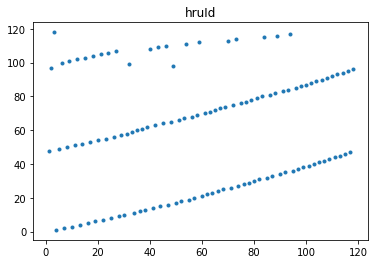

In [43]:
var = 'hruId'
plt.plot(old_forcing[var],new_forcing[var],linestyle='none',marker='.')
plt.title(var);

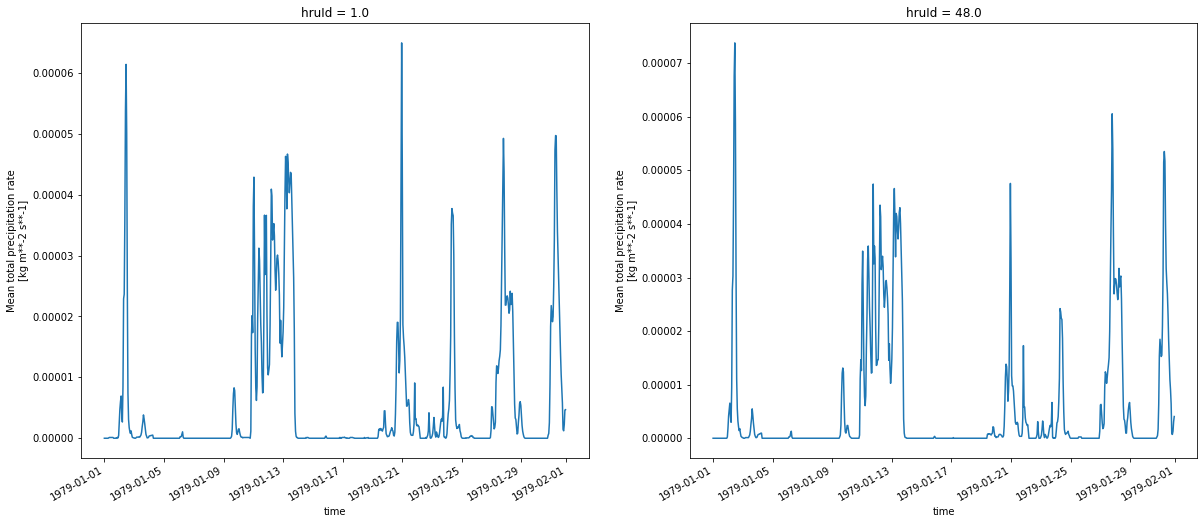

In [44]:
var = 'pptrate'
hru = 0

fig, axs = plt.subplots(1,2,figsize=(20,8))
old_forcing[var].isel(hru=hru).plot(ax=axs[0]); axs[0].set_title('hruId = {}'.format(old_forcing['hruId'].isel(hru=hru).values));
new_forcing[var].isel(hru=hru).plot(ax=axs[1]); axs[1].set_title('hruId = {}'.format(new_forcing['hruId'].isel(hru=hru).values));

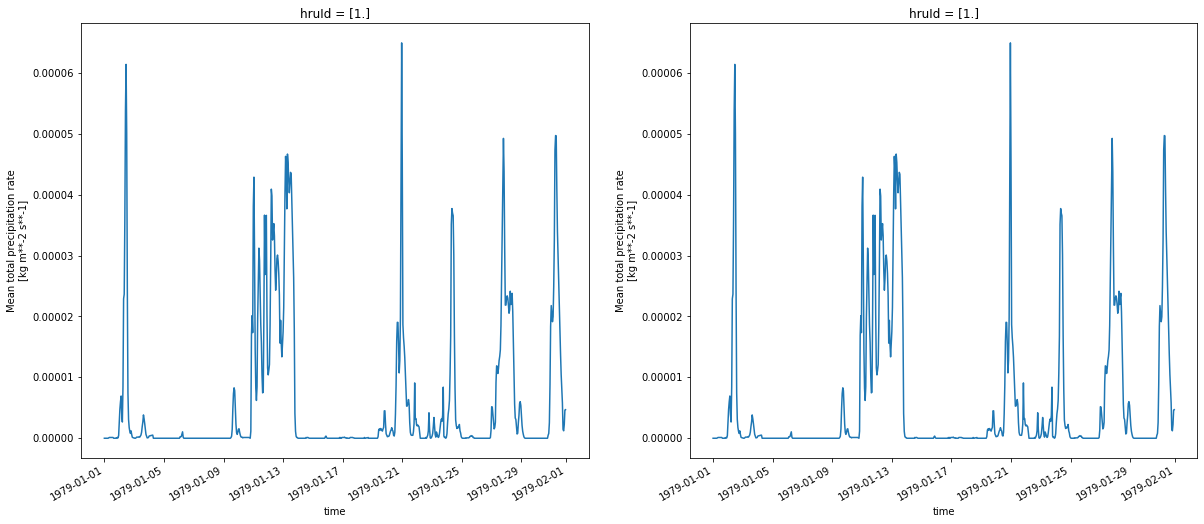

In [45]:
var = 'pptrate'
hru = 1
oldID,newID = (old_forcing['hruId'] == hru),(new_forcing['hruId'] == hru)

fig, axs = plt.subplots(1,2,figsize=(20,8))
old_forcing[var].isel(hru=oldID).plot(ax=axs[0]); axs[0].set_title('hruId = {}'.format(old_forcing['hruId'].isel(hru=oldID).values));
new_forcing[var].isel(hru=newID).plot(ax=axs[1]); axs[1].set_title('hruId = {}'.format(new_forcing['hruId'].isel(hru=newID).values));

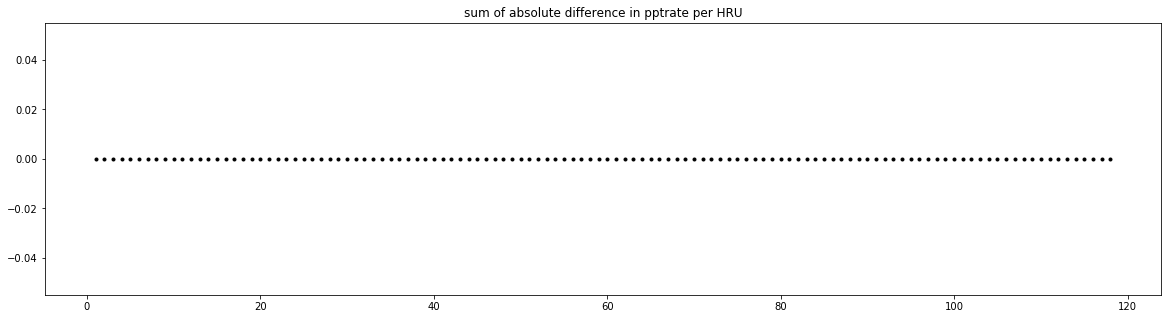

In [46]:
fig = plt.figure(figsize=(20,5))
for hruID in range(1,119):
    # find IDs
    oldID,newID = (old_forcing['hruId'] == hruID),(new_forcing['hruId'] == hruID)
    
    # calculate difference
    var = 'pptrate'
    diff = (old_forcing[var].isel(hru=oldID) - new_forcing[var].isel(hru=newID))
    
    #  plot
    plt.plot(hruID,abs(diff).sum(),linestyle='none',marker='.',color='k')
    
plt.title('sum of absolute difference in pptrate per HRU');

#### Move files to prescribed locations

In [47]:
# Remapping file 
remap_file = cndx.case_name + '_remapping.csv'
copyfile( cndx.temp_dir + remap_file, intersect_path / remap_file);

In [48]:
# Intersected shapefile
for file in glob.glob(cndx.temp_dir + cndx.case_name + '_intersected_shapefile.*'):
    copyfile( file, intersect_path / os.path.basename(file));

In [49]:
# Remove the temporary CANDEX directory to save space
try:
    rmtree(cndx.temp_dir)
except OSError as e:
    print ("Error: %s - %s." % (e.filename, e.strerror))    

#### Code provenance - intersection shapefile
Generates a basic log file in the domain folder and copies the control file and itself there.

In [50]:
# Set the log path and file name
logPath = intersect_path
log_suffix = '_catchment_forcing_intersect_log.txt'

In [51]:
# Create a log folder
logFolder = '_workflow_log'
Path( logPath / logFolder ).mkdir(parents=True, exist_ok=True)

In [52]:
# Copy this script
thisFile = '1_make_one_weighted_forcing_file.ipynb'
copyfile(thisFile, logPath / logFolder / thisFile);

In [53]:
# Get current date and time
now = datetime.now()

In [54]:
# Create a log file 
logFile = now.strftime('%Y%m%d') + log_suffix
with open( logPath / logFolder / logFile, 'w') as file:
    
    lines = ['Log generated by ' + thisFile + ' on ' + now.strftime('%Y/%m/%d %H:%M:%S') + '\n',
             'Intersect shapefiles of catchment and ERA5.']
    for txt in lines:
        file.write(txt)  

#### Code provenance - weighted forcing file
Generates a basic log file in the domain folder and copies the control file and itself there.

In [55]:
# Set the log path and file name
logPath = forcing_basin_path
log_suffix = '_create_one_weighted_forcing_file_log.txt'

In [56]:
# Create a log folder
logFolder = '_workflow_log'
Path( logPath / logFolder ).mkdir(parents=True, exist_ok=True)

In [57]:
# Copy this script
thisFile = '1_make_one_weighted_forcing_file.ipynb'
copyfile(thisFile, logPath / logFolder / thisFile);

In [58]:
# Get current date and time
now = datetime.now()

In [59]:
# Create a log file 
logFile = now.strftime('%Y%m%d') + log_suffix
with open( logPath / logFolder / logFile, 'w') as file:
    
    lines = ['Log generated by ' + thisFile + ' on ' + now.strftime('%Y/%m/%d %H:%M:%S') + '\n',
             'Made a weighted forcing file based on intersect shapefiles of catchment and ERA5.']
    for txt in lines:
        file.write(txt)  